# CloudSat Radar and Modis Cloud Top Height Comparisons for 2015 El Niño

**Spring 2017  
*Drew Camron and Matt Cann***

## Introduction

The difference in passive and active measurements can be substantial (Mahesh et al. 2004; Weisz et al. 2007). These differences can be important when studying sensitive thresholds such as cloud top height. Accurate cloud top heights are needed for weather and climate models and can have a large impact on the radiative budget. 

This study will be concerned with cloud top height measurements during the 2015-2016 El Niño in the equatorial pacific. The eastward shift and enhanced convection associated with El Niño conditions is thought to produce larger cells of convection, which increases the global average cloud top height (Xu et al. 2007; Davies and Molloy 2012). Higher average cloud top heights emit less outgoing longwave radiation and therefore have a warming effect on the planet. El Niño conditions are correlated with warmer global average surface temperatures, and accurate cloud top height retrievals may help us understand a possible connection. Feeding higher accuracy cloud top heights into weather models may also produce more accurate forecasts. Comparisons between active (MODIS) and passive (CloudSat) measurements will be drawn in this study for convection occurring on the equatorial pacific on 25 December 2015.  

The Moderate Resolution Imaging Spectroradiometer (MODIS) instrument on Aqua has 36 spectral bands with wavelengths ranging from 0.4 to 14.4 µm. MODIS is an active measuring system with a ±55° scanning window producing swaths of 2330 km and most products at 1- or 5-km spatial resolution (King et al. 1992). For this study, we used IR bands 31 and 33-36 with bandwidths ranging from 10.8 to 14.4 µm, which combine to create the level 2 cloud top height dataset. The dataset has 5-km spatial resolution.  

CloudSat is a 94-GHz nadir-looking cloud radar that tracks 176 seconds behind Aqua. CloudSat CPR measure backscattered energy from clouds and precipitation in a 1.5-km across track and 2.5-km along track footprint and ~240-m, 125 bin vertical bin resolution for a total window of 30 km (Marchand et al. 2008). For this study, we used the level 2 GEOPROF product which provides significant radar reflectivity as opposed to noise and clutter.

## Code, Analysis, and Figures

### Important Reading
[python-hdf4 (aka pyhdf) module docs](http://fhs.github.io/python-hdf4/)  
[sample modis import](http://hdfeos.org/zoo/LAADS/MOD08_D3_Cloud_Fraction_Liquid.py)  
[sample cloudsat import](http://hdfeos.org/zoo/OTHER/2010128055614_21420_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf.py)

### Importing and cleaning data
**Note**: some of the output used to investigate the HDF files has been squashed to save page space, but the code is still valid.

In [1]:
%matplotlib inline
from pyhdf.SD import *
from pyhdf.VS import *
from pyhdf.V import *
from pyhdf.HDF import *
import numpy as np

in_modis = 'Data/aqua-modis_ctpres_20151225_0140.hdf'
in_cs = 'Data/cloudsat_radar_20151225.hdf'

m = SD(in_modis, SDC.READ)
c = SD(in_cs, SDC.READ)

hm = HDF(in_modis)
hc = HDF(in_cs)

These data files are structured differently. The MODIS data stores all of its coordinates and data in datasets, to be viewed and extracted below.

In [2]:
#m.datasets() #long list of data

In [3]:
dslat_m = m.select('Latitude')
dslon_m = m.select('Longitude')
dsct_m = m.select('Cloud_Top_Height')

lat_m = dslat_m.get()    # MODIS swath latitude
lon_m = dslon_m.get()    # MODIS swath longitude
# converting to [0,360] deg E longitude
lon_m[lon_m < 0] = lon_m[lon_m < 0] + 360
ct_mi = dsct_m.get()
at = dsct_m.attributes()

In [4]:
#at

Here we can pull in some of the provided attributes. The data are not scaled or offset, but we will make sure to NaN invalid data.

In [5]:
_FillValue = at['_FillValue']
vra = at['valid_range']
ctname_m = at['long_name']
ctunits_m = at['units']

invalid = np.logical_or(ct_mi < vra[0], ct_mi > vra[1], ct_mi == _FillValue)
ct_m = ct_mi.astype(float)    # cleaned MODIS cloud-top height data
ct_m[invalid] = np.nan

Now, the cloudsat data have coordinating information hidden in the HDF vdata, which we will investigate and extract below.

In [6]:
vsc = hc.vstart()

In [7]:
#vsc.vdatainfo()

In [8]:
latc = vsc.attach('Latitude')
latc.setfields('Latitude')
n, _, _, _, _ = latc.inquire()
lat_c = np.array(latc.read(n))    # cloudsat path latitudes
latc.detach()

lonc = vsc.attach('Longitude')
lonc.setfields('Longitude')
n, _, _, _, _ = lonc.inquire()
lon_c = np.array(lonc.read(n))    # cloudsat path longitudes
lonc.detach()
# converting to [0,360] deg E longitude
lon_c[lon_c < 0] = lon_c[lon_c < 0] + 360

In [9]:
#c.datasets()

In [10]:
dshgt_c = c.select('Height')
dsref_c = c.select('Radar_Reflectivity')

hgt_ci = dshgt_c.get()
ref_ci = dsref_c.get()

As the data descriptors are a headache and a half to by-hand pull out of the HDF vgroups, they were inspected manually with HDFVIEW and imported here. Height were unscaled/unoffset, Reflectivity were scaled by 100.

In [11]:
hgtc_name = 'Height of range bin in Reflectivity/Cloud Mask above reference surface (~mean sea level).'
hgtc_units = 'm'

vra = [-5000, 30000]
_FillValue = -9999

invalid = np.logical_or(hgt_ci < vra[0], hgt_ci > vra[1], hgt_ci == _FillValue)
hgt_c = hgt_ci.astype(float)      # cleaned height data
hgt_c[invalid] = np.nan

In [12]:
refc_name = 'Radar Reflectivity Factor'
refc_units = 'dBZe'
refc_scale = 100

vra = [-4000, 5000]
_FillValue = -8192

invalid = np.logical_or(ref_ci < vra[0], ref_ci > vra[1], ref_ci == _FillValue)
ref_c_pre = ref_ci.astype(float)
ref_c_pre[invalid] = np.nan
ref_c = ref_c_pre / refc_scale    # cleaned and scaled cloudsat reflectivity data

Finally, we'll close all of our open files and datasets.

### Now we can do some data analysis!

#### Subsetting and co-locating the data
So, now we need to narrow down the cloudsat granule to our MODIS domain.

In [13]:
nlat_c_mask = np.logical_and(lat_c >= lat_m.min(), lat_c <= lat_m.max())
nlon_c_mask = np.logical_and(lon_c >= lon_m.min(), lon_c <= lon_m.max())
nref_c_mask = np.logical_and(
    nlat_c_mask.flatten() == True, nlon_c_mask.flatten() == True)

nlat_c = lat_c[nref_c_mask]
nlon_c = lon_c[nref_c_mask]
nref_c = ref_c[nref_c_mask]
nhgt_c = hgt_c[nref_c_mask]

Now that we have Cloudsat narrowed down to at least the rough MODIS domain, we will attempt to select all of the nearest points to the Cloudsat orbit track. First, we re-created the initial MODIS plot to include the subset Cloudsat track overlayed, to make sure our domains were lining up correctly.

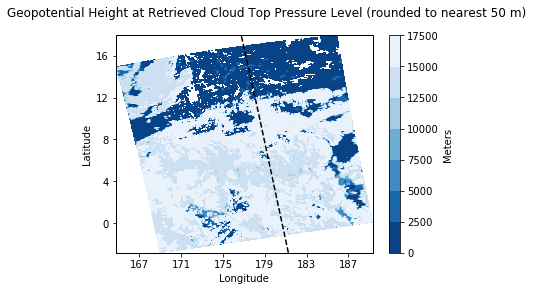

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.set_xticks(np.arange(163, 192, 4))
ax.set_yticks(np.arange(-4, 21, 4))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.suptitle(ctname_m)
c = plt.contourf(lon_m, lat_m, ct_m, cmap='Blues_r', transform=ccrs.Mercator())
cb = plt.colorbar(c)
cb.set_label('Meters')
ax2 = plt.axes(projection=ccrs.Mercator())
cs = plt.plot(nlon_c, nlat_c, 'k--')
fig.savefig('figures/modis_cloud-top-height.png')

And we can re-create our initial Cloudsat profile to actually line up with our MODIS domain.

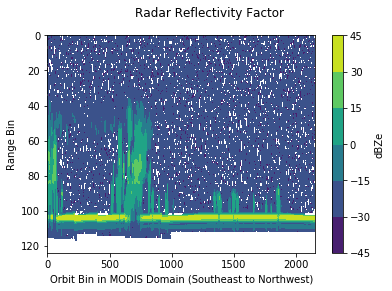

In [15]:
fig = plt.figure()
fig.suptitle(refc_name)
ax = plt.axes()
c = plt.contourf(nref_c.T)
ax.invert_yaxis()
ax.set_ylabel('Range Bin')
ax.set_xlabel('Orbit Bin in MODIS Domain (Southeast to Northwest)')
cb = plt.colorbar()
cb.set_label(refc_units)
fig.savefig('figures/cloudsat_radar-reflectivity.png')

Here we will make our cloud-top height profile from the cloudsat reflectivity by selecting the maximum height of the highest reflectivity bin greater than or equal to -18 dBZe (Wang et al. 2017).

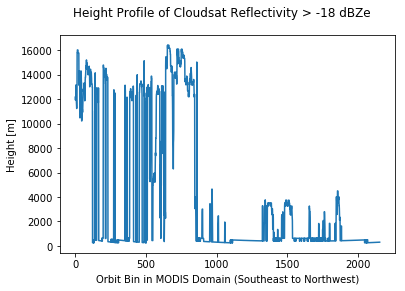

In [38]:
profile_cloudsat = np.empty(len(nref_c[:,0]))

for s in range(len(nref_c[:,0])):
    for z in range(len(nref_c[0,:])):
        if nref_c[s,z] >= -18:
            profile_cloudsat[s] = nhgt_c[s,z]
            break
        else:
            continue

profile_cloudsat[profile_cloudsat < 0] = 0

fig = plt.figure()
fig.suptitle('Height Profile of Cloudsat Reflectivity > -18 dBZe')
ax = plt.axes()
p = plt.plot(profile_cloudsat)
ax.set_ylabel('Height [m]')
ax.set_xlabel('Orbit Bin in MODIS Domain (Southeast to Northwest)')
fig.savefig('figures/cloudsat_cloudtop-height-profile.png')

Here marks where we end our analysis journey, as we struggle to deal with the data structures problem necessary. We attempted loops, distance minimization, and more where the small details and headaches were never isolated and worked out.

## Conclusion

It is difficult to draw a meaningful conclusion from this project, as we never quite reached the quantitative goals we set out to achieve. Due to data structures and programming related headaches, we were not able to produce the MODIS profile for direct comparison to the Cloudsat profile we produced. We did take away knowledge regarding the methods employed to produce these data and the general differences in passive and active techniques.

Planned and future work would involve co-locating the two datasets to produce a similar profile to the Cloudsat profile produced above. Then, simple x-y linear correlation would be employed to investigate biases between the two data sets. These same techniques could be applied across many granules in space and time to uncover possible consistent biases between these two instruments.

## References
Davies, R., and M. Molloy, 2012: Global cloud height fluctuations measured by MISR on Terra from 2000 to 2010. Geophysical Research Letters, 39, L03701, doi:10.1029/2011GL050506.  

King, M. D., Y. J. Kaufman, W. P. Menzel, and D. Tanre, 1992: Remote sensing of cloud, aerosol, and water vapor properties from the Moderate Resolution Imaging Spectrometer (MODIS). IEEE Trans. Geosci. Remote Sens., 30, 2-27.  

Mahesh, A., M. A. Gray, S. P. Palm, W. D. Hart, and J. D. Spinhirne, 2004: Passive and active detection of clouds: Comparisons between MODIS and GLAS observations, Geophys. Res. Lett., 31, L04108, doi:10.1029/2003GL018859.  

Marchand, R., G.G. Mace, T. Ackerman, and G. Stephens, 2008: Hydrometeor Detection Using CloudSat – An Earth-Orbiting 94-GHz Cloud Radar. J. Atmos. Oceanic Technol., 25, 519-533.  

Wang, Y., Y. Chen, Y. Fu, G. Liu, 2017: Identification of precipitation onset based on Cloudsat observations. J. Quan. Spec. and Rad. Trans., 188, 142-147.  

Weisz, E., J. Li, W. P. Menzel, A. K. Heidinger, B. H. Kahn, and C.-Y. Liu, 2007: Comparison of AIRS, MODIS, CloudSat and CALIPSO cloud top height retrievals. Geophys. Res. Lett., 34, L17811, doi:10.1029/2007GL030676.  

Xu, K.-M. et al, 2007: Statistical analyses of satellite cloud object data from CERS, part II: Tropical convective cloud objects during the 1998 El Nino and evidence for supporting the fixed anvil temperature hypothesis. J. Climate, 20, 819-842.